# 2D Acoustic Wave
---
- Model Setup: [this link](https://github.com/devitocodes/devito/blob/master/examples/seismic/tutorials/01_modelling.ipynb)

- target: $c(x, z)^2$.

- rescaling: $x' = x/1000, z' = z/1000, t' = t/1000$.

---

# Direct Problem only,  without Source;

# Full Snapshots

# Exact velocity field

# target: learn the forward model and try to reduce residue error

In [1]:
NAME = "0727_full_snapshots_and_velocity"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers

import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *

from collections import namedtuple

In [3]:
def siren_layer_params(key, scale, m, n):
	w_key, b_key = random.split(key)
	return random.uniform(w_key, (m, n), jnp.float32, minval = -scale, maxval = scale), jnp.zeros((n, ), jnp.float32)

def init_siren_params(key, layers, c0, w0, w1):
	keys = random.split(key, len(layers))
	return [siren_layer_params(keys[0], w0*jnp.sqrt(c0/layers[0]), layers[0], layers[1])] + \
			[siren_layer_params(k, jnp.sqrt(c0/m), m, n) for m, n, k in zip(layers[1:-2], layers[2:-1], keys[1:-2])] + \
			[siren_layer_params(keys[-1], w1*jnp.sqrt(c0/layers[-2]), layers[-2], layers[-1])]

layers = [3, 32, 32, 32, 32, 32, 32, 32, 32, 1] # (x, z, t) -> p
c0 = 1.0
w0 = 10.0
w1 = 1.0
lambda_0 = 1e-10
direct_params = init_siren_params(random.PRNGKey(0), layers, c0, w0, w1)

# direct_iteration = 100000
# direct_params = np.load("models/{}/iteration_{}/params.npy".format(NAME, direct_iteration), allow_pickle=True)
# direct_params = [[jnp.asarray(arr) for arr in Arr] for Arr in direct_params]

@jax.jit
def scalar_direct_model(params, x, z, t):
	x_ = jnp.hstack([x, z, t])
	for w, b in params[:-1]:
		x_ = jnp.sin(jnp.dot(x_, w) + b)
	return jnp.sum(jnp.dot(x_, params[-1][0]) + params[-1][1])


from jax import lax

@jax.jit
def scalar_inverse_model(x, z): # scaled to [-1, 1]
	return lax.cond(z[0] >= 0.0, z, lambda z: z*0+2.5, z, lambda z: z*0+1.5)

direct_model = jax.jit(jax.vmap(scalar_direct_model, in_axes = (None, 0, 0, 0)))
inverse_model = jax.jit(jax.vmap(scalar_inverse_model, in_axes = (0, 0)))

In [4]:
@jax.jit
def mse(pred, true):
	return jnp.mean(jnp.square(pred - true))

@jax.jit
def l2_regularization(params, lambda_0):
	res = 0
	for p in params:
		res += jnp.sum(jnp.square(p[0]))
	return res*lambda_0

@jax.jit
def scalar_dp_dx(params, x, z, t):
    return jnp.sum(jax.grad(scalar_direct_model, 1)(params, x, z, t))

@jax.jit
def scalar_dp_dz(params, x, z, t):
    return jnp.sum(jax.grad(scalar_direct_model, 2)(params, x, z, t))

@jax.jit
def scalar_dp_dt(params, x, z, t):
    return jnp.sum(jax.grad(scalar_direct_model, 3)(params, x, z, t))

@jax.jit
def dp_dxx(params, x, z, t):
    return jax.grad(scalar_dp_dx, 1)(params, x, z, t)

@jax.jit
def dp_dzz(params, x, z, t):
    return jax.grad(scalar_dp_dz, 2)(params, x, z, t)

@jax.jit
def dp_dtt(params, x, z, t):
    return jax.grad(scalar_dp_dt, 3)(params, x, z, t)

@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet = batch["collocation"], batch["dirichlet"]
	direct_params = params
    
	c = inverse_model(collocation.x, collocation.z)
	dp_dtt_ = dp_dtt(direct_params, collocation.x, collocation.z, collocation.t)
	dp_dxx_ = dp_dxx(direct_params, collocation.x, collocation.z, collocation.t)
	dp_dzz_ = dp_dzz(direct_params, collocation.x, collocation.z, collocation.t)
	p_pred = direct_model(direct_params, dirichlet.x, dirichlet.z, dirichlet.t).reshape((-1, 1))
	
	loss_c = mse(dp_dtt_ - c**2*(dp_dxx_ + dp_dzz_), 0)
	loss_d = mse(p_pred, dirichlet.p)
	return loss_c, loss_d

@jax.jit
def loss_fn(params, batch):
	
	loss_c, loss_d = loss_fn_(params, batch)
	return batch["Weights"]["c"]*loss_c + batch["Weights"]["d"]*loss_d + l2_regularization(params[0], lambda_0)

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	loss_c, loss_d = loss_fn_(params, batch)
	return batch["Weights"]["c"]*loss_c + batch["Weights"]["d"]*loss_d, loss_c, loss_d


In [5]:
import pickle 
with open("dataset_single_source.pkl", "rb") as file:
	x, z, t, p = pickle.load(file)
	
tzx = tensor_grid([t, z, x])
x, z, t = tzx[:, 2:3], tzx[:, 1:2], tzx[:, 0:1]
p = p.reshape((-1, 1))

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "z", "t", "p"])
dirichlet = dataset_Dirichlet(*map(lambda x: jnp.array(x), [x, z, t, p]))


class Batch_Generator:
	def __init__(self, key, dataset, batch_size):
		self.key = key
		self.dataset = dataset
		self.batch_size = batch_size
		self.index = jnp.arange(dataset[0].shape[0])
		self.pointer = 0
		self._shuffle()
		
	def _shuffle(self):
		key, subkey = random.split(self.key)
		self.index = random.permutation(subkey, jnp.arange(self.dataset[0].shape[0]))
		self.key = key
		
	def __iter__(self):
		return self
	
	def __next__(self):
		if self.pointer >= len(self.index):
			self._shuffle()
			self.pointer = 0
		self.pointer += self.batch_size
		index_ = self.index[self.pointer-self.batch_size:self.pointer]
		return [d[index_, :] for d in self.dataset]

In [6]:
lr = 1e-3
start_iteration = 0
iterations = 100000
print_every = 500
save_every = 10000
batch_size_collocation = 10000
batch_size_dirichlet = 10000
w_c = 1e-4
w_d = 1.0

key = random.PRNGKey(1)
Dirichlet = Batch_Generator(key, dirichlet, batch_size_dirichlet)
params = direct_params

opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
for iteration in range(start_iteration+1, start_iteration+iterations+1):
	diri = dataset_Dirichlet(*next(Dirichlet))
	collo = diri
	batch = {
		"dirichlet": diri,
		"collocation": collo,
		"Weights": {"c": w_c, "d": w_d}
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/07/31, 08:33:33, Iteration: 500, Train Loss: 1.2448e+00, c: 6.5214e+02, d: 1.1796e+00
2020/07/31, 08:33:38, Iteration: 1000, Train Loss: 8.7120e-01, c: 1.7045e+03, d: 7.0075e-01
2020/07/31, 08:33:43, Iteration: 1500, Train Loss: 8.0317e-01, c: 1.7404e+03, d: 6.2912e-01
2020/07/31, 08:33:48, Iteration: 2000, Train Loss: 7.7121e-01, c: 1.7465e+03, d: 5.9656e-01
2020/07/31, 08:33:53, Iteration: 2500, Train Loss: 7.1020e-01, c: 1.9583e+03, d: 5.1437e-01
2020/07/31, 08:33:58, Iteration: 3000, Train Loss: 6.7821e-01, c: 2.0463e+03, d: 4.7358e-01
2020/07/31, 08:34:03, Iteration: 3500, Train Loss: 6.2507e-01, c: 1.6913e+03, d: 4.5594e-01
2020/07/31, 08:34:09, Iteration: 4000, Train Loss: 6.9184e-01, c: 2.1582e+03, d: 4.7602e-01
2020/07/31, 08:34:14, Iteration: 4500, Train Loss: 6.6354e-01, c: 2.0164e+03, d: 4.6190e-01
2020/07/31, 08:34:19, Iteration: 5000, Train Loss: 6.1322e-01, c: 1.8719e+03, d: 4.2603e-01
2020/07/31, 08:34:24, Iteration: 5500, Train Loss: 5.9993e-01, c: 1.9343e+03, d: 

2020/07/31, 08:41:10, Iteration: 45000, Train Loss: 1.4559e-01, c: 4.6081e+02, d: 9.9512e-02
2020/07/31, 08:41:15, Iteration: 45500, Train Loss: 1.6521e-01, c: 6.5143e+02, d: 1.0007e-01
2020/07/31, 08:41:20, Iteration: 46000, Train Loss: 1.4177e-01, c: 4.4320e+02, d: 9.7451e-02
2020/07/31, 08:41:25, Iteration: 46500, Train Loss: 1.3780e-01, c: 4.3583e+02, d: 9.4220e-02
2020/07/31, 08:41:30, Iteration: 47000, Train Loss: 1.3327e-01, c: 3.9768e+02, d: 9.3503e-02
2020/07/31, 08:41:36, Iteration: 47500, Train Loss: 1.3764e-01, c: 4.1523e+02, d: 9.6115e-02
2020/07/31, 08:41:41, Iteration: 48000, Train Loss: 1.6750e-01, c: 5.4491e+02, d: 1.1301e-01
2020/07/31, 08:41:46, Iteration: 48500, Train Loss: 1.3544e-01, c: 4.2106e+02, d: 9.3333e-02
2020/07/31, 08:41:51, Iteration: 49000, Train Loss: 1.3313e-01, c: 4.4596e+02, d: 8.8531e-02
2020/07/31, 08:41:56, Iteration: 49500, Train Loss: 1.3458e-01, c: 4.1330e+02, d: 9.3249e-02
2020/07/31, 08:42:01, Iteration: 50000, Train Loss: 1.3454e-01, c: 3.9

2020/07/31, 08:48:41, Iteration: 89500, Train Loss: 9.9140e-02, c: 3.6250e+02, d: 6.2890e-02
2020/07/31, 08:48:46, Iteration: 90000, Train Loss: 1.4772e+00, c: 9.5357e+03, d: 5.2361e-01
2020/07/31, 08:48:51, Iteration: 90500, Train Loss: 1.3196e-01, c: 5.2520e+02, d: 7.9445e-02
2020/07/31, 08:48:56, Iteration: 91000, Train Loss: 1.0607e-01, c: 3.9656e+02, d: 6.6414e-02
2020/07/31, 08:49:02, Iteration: 91500, Train Loss: 9.8498e-02, c: 3.5801e+02, d: 6.2697e-02
2020/07/31, 08:49:07, Iteration: 92000, Train Loss: 9.6073e-02, c: 3.4884e+02, d: 6.1189e-02
2020/07/31, 08:49:12, Iteration: 92500, Train Loss: 1.0589e-01, c: 4.1092e+02, d: 6.4795e-02
2020/07/31, 08:49:17, Iteration: 93000, Train Loss: 8.9667e-02, c: 3.0487e+02, d: 5.9180e-02
2020/07/31, 08:49:22, Iteration: 93500, Train Loss: 3.9098e-01, c: 1.6237e+03, d: 2.2862e-01
2020/07/31, 08:49:27, Iteration: 94000, Train Loss: 1.6863e-01, c: 8.1901e+02, d: 8.6728e-02
2020/07/31, 08:49:32, Iteration: 94500, Train Loss: 9.8987e-02, c: 3.7

In [10]:
start_iteration = 100000
iterations = 200000
print_every = 1000
save_every = 10000
batch_size_collocation = 10000
batch_size_dirichlet = 10000
w_c = 1e-4
w_d = 1.0

for iteration in range(start_iteration+1, start_iteration+iterations+1):
	diri = dataset_Dirichlet(*next(Dirichlet))
	collo = diri
	batch = {
		"dirichlet": diri,
		"collocation": collo,
		"Weights": {"c": w_c, "d": w_d}
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/07/31, 08:51:46, Iteration: 101000, Train Loss: 9.4739e-02, c: 3.5820e+02, d: 5.8919e-02
2020/07/31, 08:51:56, Iteration: 102000, Train Loss: 9.1042e-02, c: 3.3357e+02, d: 5.7685e-02
2020/07/31, 08:52:05, Iteration: 103000, Train Loss: 9.5842e-02, c: 3.9767e+02, d: 5.6075e-02
2020/07/31, 08:52:15, Iteration: 104000, Train Loss: 9.8292e-02, c: 3.6444e+02, d: 6.1847e-02
2020/07/31, 08:52:26, Iteration: 105000, Train Loss: 9.1172e-02, c: 3.3073e+02, d: 5.8100e-02
2020/07/31, 08:52:36, Iteration: 106000, Train Loss: 9.3569e-02, c: 3.5866e+02, d: 5.7703e-02
2020/07/31, 08:52:47, Iteration: 107000, Train Loss: 9.3313e-02, c: 3.5210e+02, d: 5.8104e-02
2020/07/31, 08:52:58, Iteration: 108000, Train Loss: 8.5130e-02, c: 3.0820e+02, d: 5.4310e-02
2020/07/31, 08:53:08, Iteration: 109000, Train Loss: 8.5797e-02, c: 3.0598e+02, d: 5.5198e-02
2020/07/31, 08:53:19, Iteration: 110000, Train Loss: 9.5991e-02, c: 3.3660e+02, d: 6.2331e-02
2020/07/31, 08:53:29, Iteration: 111000, Train Loss: 9.2431e

2020/07/31, 09:06:41, Iteration: 189000, Train Loss: 7.9882e-02, c: 3.3733e+02, d: 4.6149e-02
2020/07/31, 09:06:51, Iteration: 190000, Train Loss: 8.3770e-02, c: 3.5923e+02, d: 4.7847e-02
2020/07/31, 09:07:01, Iteration: 191000, Train Loss: 7.8988e-02, c: 3.3356e+02, d: 4.5632e-02
2020/07/31, 09:07:11, Iteration: 192000, Train Loss: 7.9872e-02, c: 3.4015e+02, d: 4.5857e-02
2020/07/31, 09:07:21, Iteration: 193000, Train Loss: 1.2224e-01, c: 5.4616e+02, d: 6.7627e-02
2020/07/31, 09:07:32, Iteration: 194000, Train Loss: 7.3608e-02, c: 2.8739e+02, d: 4.4869e-02
2020/07/31, 09:07:42, Iteration: 195000, Train Loss: 9.5858e-02, c: 4.4768e+02, d: 5.1090e-02
2020/07/31, 09:07:52, Iteration: 196000, Train Loss: 7.3799e-02, c: 2.8765e+02, d: 4.5034e-02
2020/07/31, 09:08:02, Iteration: 197000, Train Loss: 7.4031e-02, c: 3.2415e+02, d: 4.1616e-02
2020/07/31, 09:08:12, Iteration: 198000, Train Loss: 7.2650e-02, c: 2.7714e+02, d: 4.4936e-02
2020/07/31, 09:08:22, Iteration: 199000, Train Loss: 7.7786e

2020/07/31, 09:21:32, Iteration: 277000, Train Loss: 9.8603e-02, c: 4.7388e+02, d: 5.1216e-02
2020/07/31, 09:21:41, Iteration: 278000, Train Loss: 6.4245e-02, c: 2.7381e+02, d: 3.6864e-02
2020/07/31, 09:21:51, Iteration: 279000, Train Loss: 1.1824e-01, c: 7.4898e+02, d: 4.3339e-02
2020/07/31, 09:22:01, Iteration: 280000, Train Loss: 1.5586e-01, c: 8.3876e+02, d: 7.1987e-02
2020/07/31, 09:22:11, Iteration: 281000, Train Loss: 6.8221e-02, c: 3.1988e+02, d: 3.6232e-02
2020/07/31, 09:22:21, Iteration: 282000, Train Loss: 7.0499e-02, c: 3.5013e+02, d: 3.5486e-02
2020/07/31, 09:22:31, Iteration: 283000, Train Loss: 7.2037e-02, c: 3.0449e+02, d: 4.1588e-02
2020/07/31, 09:22:41, Iteration: 284000, Train Loss: 7.3703e-02, c: 3.2167e+02, d: 4.1536e-02
2020/07/31, 09:22:51, Iteration: 285000, Train Loss: 7.5082e-02, c: 3.9972e+02, d: 3.5110e-02
2020/07/31, 09:23:01, Iteration: 286000, Train Loss: 6.8651e-02, c: 2.9601e+02, d: 3.9050e-02
2020/07/31, 09:23:11, Iteration: 287000, Train Loss: 7.0990e

In [13]:
start_iteration = 300000
iterations = 300000
print_every = 1000
save_every = 10000
batch_size_collocation = 10000
batch_size_dirichlet = 10000
w_c = 1e-3
w_d = 10.0

for iteration in range(start_iteration+1, start_iteration+iterations+1):
	diri = dataset_Dirichlet(*next(Dirichlet))
	collo = diri
	batch = {
		"dirichlet": diri,
		"collocation": collo,
		"Weights": {"c": w_c, "d": w_d}
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/07/31, 11:02:08, Iteration: 301000, Train Loss: 8.9926e-01, c: 3.8030e+02, d: 5.1896e-02
2020/07/31, 11:02:17, Iteration: 302000, Train Loss: 7.9792e-01, c: 4.1587e+02, d: 3.8206e-02
2020/07/31, 11:02:25, Iteration: 303000, Train Loss: 6.7876e-01, c: 2.9911e+02, d: 3.7965e-02
2020/07/31, 11:02:34, Iteration: 304000, Train Loss: 1.0593e+00, c: 6.1842e+02, d: 4.4084e-02
2020/07/31, 11:02:43, Iteration: 305000, Train Loss: 6.5860e-01, c: 2.9176e+02, d: 3.6684e-02
2020/07/31, 11:02:52, Iteration: 306000, Train Loss: 7.0958e-01, c: 3.5286e+02, d: 3.5671e-02
2020/07/31, 11:03:00, Iteration: 307000, Train Loss: 1.6732e+00, c: 9.9431e+02, d: 6.7892e-02
2020/07/31, 11:03:09, Iteration: 308000, Train Loss: 5.6946e-01, c: 2.5687e+02, d: 3.1259e-02
2020/07/31, 11:03:18, Iteration: 309000, Train Loss: 8.8851e-01, c: 4.4692e+02, d: 4.4159e-02
2020/07/31, 11:03:28, Iteration: 310000, Train Loss: 7.5447e-01, c: 3.5446e+02, d: 4.0001e-02
2020/07/31, 11:03:37, Iteration: 311000, Train Loss: 7.6217e

2020/07/31, 11:16:53, Iteration: 389000, Train Loss: 1.8145e+00, c: 1.0860e+03, d: 7.2844e-02
2020/07/31, 11:17:03, Iteration: 390000, Train Loss: 5.7919e-01, c: 2.5614e+02, d: 3.2305e-02
2020/07/31, 11:17:13, Iteration: 391000, Train Loss: 5.7056e-01, c: 2.5125e+02, d: 3.1931e-02
2020/07/31, 11:17:23, Iteration: 392000, Train Loss: 5.9841e-01, c: 2.8621e+02, d: 3.1219e-02
2020/07/31, 11:17:33, Iteration: 393000, Train Loss: 5.9204e-01, c: 2.5589e+02, d: 3.3615e-02
2020/07/31, 11:17:43, Iteration: 394000, Train Loss: 5.8937e-01, c: 2.7965e+02, d: 3.0972e-02
2020/07/31, 11:17:54, Iteration: 395000, Train Loss: 2.6589e+00, c: 2.1440e+03, d: 5.1492e-02
2020/07/31, 11:18:04, Iteration: 396000, Train Loss: 1.0091e+00, c: 6.1435e+02, d: 3.9473e-02
2020/07/31, 11:18:14, Iteration: 397000, Train Loss: 5.1600e-01, c: 2.3857e+02, d: 2.7743e-02
2020/07/31, 11:18:24, Iteration: 398000, Train Loss: 5.5190e-01, c: 2.4836e+02, d: 3.0354e-02
2020/07/31, 11:18:34, Iteration: 399000, Train Loss: 5.9451e

2020/07/31, 11:31:46, Iteration: 477000, Train Loss: 4.4487e-01, c: 2.0198e+02, d: 2.4290e-02
2020/07/31, 11:31:56, Iteration: 478000, Train Loss: 4.4264e-01, c: 2.0628e+02, d: 2.3636e-02
2020/07/31, 11:32:06, Iteration: 479000, Train Loss: 4.5817e-01, c: 2.2039e+02, d: 2.3778e-02
2020/07/31, 11:32:16, Iteration: 480000, Train Loss: 5.3098e-01, c: 2.3933e+02, d: 2.9165e-02
2020/07/31, 11:32:26, Iteration: 481000, Train Loss: 4.9263e-01, c: 2.2612e+02, d: 2.6651e-02
2020/07/31, 11:32:36, Iteration: 482000, Train Loss: 5.2562e-01, c: 2.7272e+02, d: 2.5290e-02
2020/07/31, 11:32:46, Iteration: 483000, Train Loss: 6.3955e-01, c: 3.5805e+02, d: 2.8150e-02
2020/07/31, 11:32:56, Iteration: 484000, Train Loss: 5.1963e-01, c: 2.6136e+02, d: 2.5827e-02
2020/07/31, 11:33:06, Iteration: 485000, Train Loss: 5.1575e-01, c: 2.5669e+02, d: 2.5906e-02
2020/07/31, 11:33:17, Iteration: 486000, Train Loss: 4.7018e-01, c: 2.0934e+02, d: 2.6084e-02
2020/07/31, 11:33:27, Iteration: 487000, Train Loss: 4.4771e

2020/07/31, 11:46:38, Iteration: 565000, Train Loss: 3.9136e-01, c: 1.9311e+02, d: 1.9825e-02
2020/07/31, 11:46:48, Iteration: 566000, Train Loss: 4.6131e-01, c: 2.4122e+02, d: 2.2009e-02
2020/07/31, 11:46:58, Iteration: 567000, Train Loss: 5.1762e-01, c: 2.9854e+02, d: 2.1908e-02
2020/07/31, 11:47:08, Iteration: 568000, Train Loss: 3.5275e-01, c: 1.5379e+02, d: 1.9896e-02
2020/07/31, 11:47:19, Iteration: 569000, Train Loss: 4.2849e-01, c: 2.2763e+02, d: 2.0086e-02
2020/07/31, 11:47:29, Iteration: 570000, Train Loss: 3.6625e-01, c: 1.6464e+02, d: 2.0161e-02
2020/07/31, 11:47:39, Iteration: 571000, Train Loss: 4.4507e-01, c: 2.3286e+02, d: 2.1221e-02
2020/07/31, 11:47:49, Iteration: 572000, Train Loss: 4.8980e-01, c: 2.9261e+02, d: 1.9719e-02
2020/07/31, 11:47:59, Iteration: 573000, Train Loss: 4.8751e-01, c: 2.8082e+02, d: 2.0670e-02
2020/07/31, 11:48:09, Iteration: 574000, Train Loss: 3.7391e-01, c: 1.7918e+02, d: 1.9473e-02
2020/07/31, 11:48:19, Iteration: 575000, Train Loss: 3.6363e

In [14]:
start_iteration = 600000
iterations = 500000
print_every = 1000
save_every = 10000
batch_size_collocation = 10000
batch_size_dirichlet = 10000
w_c = 5e-3
w_d = 10.0

for iteration in range(start_iteration+1, start_iteration+iterations+1):
	diri = dataset_Dirichlet(*next(Dirichlet))
	collo = diri
	batch = {
		"dirichlet": diri,
		"collocation": collo,
		"Weights": {"c": w_c, "d": w_d}
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/07/31, 11:52:43, Iteration: 601000, Train Loss: 2.9035e+00, c: 2.8527e+02, d: 1.4772e-01
2020/07/31, 11:52:53, Iteration: 602000, Train Loss: 2.4307e+00, c: 2.3144e+02, d: 1.2735e-01
2020/07/31, 11:53:04, Iteration: 603000, Train Loss: 2.0789e+00, c: 2.1781e+02, d: 9.8980e-02
2020/07/31, 11:53:14, Iteration: 604000, Train Loss: 1.3907e+00, c: 1.2463e+02, d: 7.6757e-02
2020/07/31, 11:53:24, Iteration: 605000, Train Loss: 1.2859e+00, c: 1.1926e+02, d: 6.8953e-02
2020/07/31, 11:53:34, Iteration: 606000, Train Loss: 1.2468e+00, c: 1.1407e+02, d: 6.7648e-02
2020/07/31, 11:53:44, Iteration: 607000, Train Loss: 1.3324e+00, c: 1.2062e+02, d: 7.2930e-02
2020/07/31, 11:53:54, Iteration: 608000, Train Loss: 1.3051e+00, c: 1.1973e+02, d: 7.0644e-02
2020/07/31, 11:54:05, Iteration: 609000, Train Loss: 1.2555e+00, c: 1.1503e+02, d: 6.8034e-02
2020/07/31, 11:54:15, Iteration: 610000, Train Loss: 1.2289e+00, c: 1.1197e+02, d: 6.6912e-02
2020/07/31, 11:54:25, Iteration: 611000, Train Loss: 1.1898e

2020/07/31, 12:07:37, Iteration: 689000, Train Loss: 1.2669e+00, c: 1.3825e+02, d: 5.7571e-02
2020/07/31, 12:07:47, Iteration: 690000, Train Loss: 1.1218e+00, c: 1.1328e+02, d: 5.5538e-02
2020/07/31, 12:07:57, Iteration: 691000, Train Loss: 2.1991e+00, c: 3.1623e+02, d: 6.1797e-02
2020/07/31, 12:08:08, Iteration: 692000, Train Loss: 8.3813e-01, c: 6.9805e+01, d: 4.8911e-02
2020/07/31, 12:08:18, Iteration: 693000, Train Loss: 1.0076e+00, c: 1.0347e+02, d: 4.9029e-02
2020/07/31, 12:08:28, Iteration: 694000, Train Loss: 1.1227e+00, c: 9.2050e+01, d: 6.6241e-02
2020/07/31, 12:08:38, Iteration: 695000, Train Loss: 1.1741e+00, c: 1.2255e+02, d: 5.6136e-02
2020/07/31, 12:08:48, Iteration: 696000, Train Loss: 8.3971e-01, c: 6.6075e+01, d: 5.0934e-02
2020/07/31, 12:08:58, Iteration: 697000, Train Loss: 1.3091e+00, c: 1.5759e+02, d: 5.2114e-02
2020/07/31, 12:09:08, Iteration: 698000, Train Loss: 8.6701e-01, c: 7.6368e+01, d: 4.8517e-02
2020/07/31, 12:09:18, Iteration: 699000, Train Loss: 1.3256e

2020/07/31, 12:22:30, Iteration: 777000, Train Loss: 7.9314e-01, c: 6.7351e+01, d: 4.5638e-02
2020/07/31, 12:22:41, Iteration: 778000, Train Loss: 2.5061e+00, c: 3.7387e+02, d: 6.3673e-02
2020/07/31, 12:22:51, Iteration: 779000, Train Loss: 7.8285e-01, c: 6.7264e+01, d: 4.4653e-02
2020/07/31, 12:23:01, Iteration: 780000, Train Loss: 9.3511e-01, c: 7.8175e+01, d: 5.4424e-02
2020/07/31, 12:23:11, Iteration: 781000, Train Loss: 1.7227e+00, c: 2.3747e+02, d: 5.3535e-02
2020/07/31, 12:23:21, Iteration: 782000, Train Loss: 8.4721e-01, c: 7.9441e+01, d: 4.5000e-02
2020/07/31, 12:23:31, Iteration: 783000, Train Loss: 9.7302e-01, c: 1.0370e+02, d: 4.5453e-02
2020/07/31, 12:23:42, Iteration: 784000, Train Loss: 5.1606e+00, c: 4.0837e+02, d: 3.1188e-01
2020/07/31, 12:23:52, Iteration: 785000, Train Loss: 1.7219e+00, c: 1.6317e+02, d: 9.0603e-02
2020/07/31, 12:24:02, Iteration: 786000, Train Loss: 1.6183e+00, c: 1.7289e+02, d: 7.5383e-02
2020/07/31, 12:24:12, Iteration: 787000, Train Loss: 1.1271e

2020/07/31, 12:37:23, Iteration: 865000, Train Loss: 8.4468e-01, c: 7.3778e+01, d: 4.7580e-02
2020/07/31, 12:37:34, Iteration: 866000, Train Loss: 8.0813e-01, c: 6.6393e+01, d: 4.7616e-02
2020/07/31, 12:37:44, Iteration: 867000, Train Loss: 1.0059e+00, c: 7.7910e+01, d: 6.1633e-02
2020/07/31, 12:37:54, Iteration: 868000, Train Loss: 9.8329e-01, c: 1.0147e+02, d: 4.7595e-02
2020/07/31, 12:38:04, Iteration: 869000, Train Loss: 1.0319e+00, c: 1.0750e+02, d: 4.9434e-02
2020/07/31, 12:38:14, Iteration: 870000, Train Loss: 1.0386e+00, c: 1.0754e+02, d: 5.0091e-02
2020/07/31, 12:38:24, Iteration: 871000, Train Loss: 7.9916e-01, c: 6.1881e+01, d: 4.8976e-02
2020/07/31, 12:38:35, Iteration: 872000, Train Loss: 8.8498e-01, c: 8.3578e+01, d: 4.6709e-02
2020/07/31, 12:38:45, Iteration: 873000, Train Loss: 8.5084e-01, c: 7.9858e+01, d: 4.5155e-02
2020/07/31, 12:38:55, Iteration: 874000, Train Loss: 1.0347e+00, c: 8.3940e+01, d: 6.1505e-02
2020/07/31, 12:39:05, Iteration: 875000, Train Loss: 1.0135e

2020/07/31, 12:52:17, Iteration: 953000, Train Loss: 8.2569e-01, c: 6.7200e+01, d: 4.8969e-02
2020/07/31, 12:52:27, Iteration: 954000, Train Loss: 8.9815e-01, c: 8.8298e+01, d: 4.5666e-02
2020/07/31, 12:52:37, Iteration: 955000, Train Loss: 1.0140e+00, c: 7.0220e+01, d: 6.6289e-02
2020/07/31, 12:52:47, Iteration: 956000, Train Loss: 9.1522e-01, c: 8.9378e+01, d: 4.6833e-02
2020/07/31, 12:52:58, Iteration: 957000, Train Loss: 9.3091e-01, c: 9.7118e+01, d: 4.4532e-02
2020/07/31, 12:53:08, Iteration: 958000, Train Loss: 1.0701e+00, c: 9.9559e+01, d: 5.7230e-02
2020/07/31, 12:53:18, Iteration: 959000, Train Loss: 9.2147e-01, c: 8.6665e+01, d: 4.8815e-02
2020/07/31, 12:53:28, Iteration: 960000, Train Loss: 1.0229e+00, c: 1.1370e+02, d: 4.5438e-02
2020/07/31, 12:53:38, Iteration: 961000, Train Loss: 8.2339e-01, c: 6.0987e+01, d: 5.1846e-02
2020/07/31, 12:53:48, Iteration: 962000, Train Loss: 1.3992e+00, c: 1.9416e+02, d: 4.2844e-02
2020/07/31, 12:53:58, Iteration: 963000, Train Loss: 8.2366e

2020/07/31, 13:06:54, Iteration: 1040000, Train Loss: 7.4819e-01, c: 6.4579e+01, d: 4.2529e-02
2020/07/31, 13:07:04, Iteration: 1041000, Train Loss: 1.5027e+00, c: 1.3389e+02, d: 8.3329e-02
2020/07/31, 13:07:14, Iteration: 1042000, Train Loss: 8.9706e-01, c: 6.7909e+01, d: 5.5752e-02
2020/07/31, 13:07:24, Iteration: 1043000, Train Loss: 1.1455e+00, c: 1.2070e+02, d: 5.4205e-02
2020/07/31, 13:07:34, Iteration: 1044000, Train Loss: 9.8289e-01, c: 9.7336e+01, d: 4.9621e-02
2020/07/31, 13:07:44, Iteration: 1045000, Train Loss: 1.0561e+00, c: 1.0661e+02, d: 5.2304e-02
2020/07/31, 13:07:54, Iteration: 1046000, Train Loss: 8.8951e-01, c: 7.5905e+01, d: 5.0999e-02
2020/07/31, 13:08:04, Iteration: 1047000, Train Loss: 1.1221e+00, c: 1.1385e+02, d: 5.5281e-02
2020/07/31, 13:08:14, Iteration: 1048000, Train Loss: 8.1873e-01, c: 6.8249e+01, d: 4.7749e-02
2020/07/31, 13:08:24, Iteration: 1049000, Train Loss: 9.2088e-01, c: 9.1665e+01, d: 4.6256e-02
2020/07/31, 13:08:34, Iteration: 1050000, Train Lo

In [15]:
import pickle 
with open("dataset_single_source.pkl", "rb") as file:
	x, z, t, p = pickle.load(file)
	
import matplotlib as mpl
from matplotlib.cm import cool
from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib import pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

def plot_(t_index):
	tzx_test = tensor_grid([t[t_index], z, x])
	p_pred = direct_model(get_params(opt_state), tzx_test[:, 2:3], tzx_test[:, 1:2], tzx_test[:, 0:1]).reshape((len(z), len(x)))
	p_true = p[t_index, :].reshape((len(z), len(x)))

	cmap = cool
	norm = Normalize(vmin=-10, vmax=10)

	X, Z = np.meshgrid(x, z)
	fig, ax = plt.subplots(1, 3, figsize = (15, 5))
	fig.subplots_adjust(right = 1.0)

	im0 = ax[0].contourf(X, Z, p_true, cmap = cmap, norm = norm, levels = 1000)
	ax[0].set_title("true")
	divider = make_axes_locatable(ax[0])
	cax = divider.append_axes('right', size='5%', pad=0.05)
	mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

	# norm = mpl.colors.Normalize(vmin=1.0, vmax=3.0)
	im1 = ax[1].contourf(X, Z, p_pred, cmap = cmap, norm = norm, levels = 1000)
	ax[1].set_title("pred")
	divider = make_axes_locatable(ax[1])
	cax = divider.append_axes('right', size='5%', pad=0.05)
	mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

	norm = mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
	im2 = ax[2].contourf(X, Z, p_true - p_pred, cmap = cmap, norm = norm, levels = 1000)
	ax[2].set_title("t = {:.4e}, MSE: {}".format(t[t_index]/2, np.mean(np.square(p_true - p_pred))))
	divider = make_axes_locatable(ax[2])
	cax = divider.append_axes('right', size='5%', pad=0.05)
	mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

	plt.show()

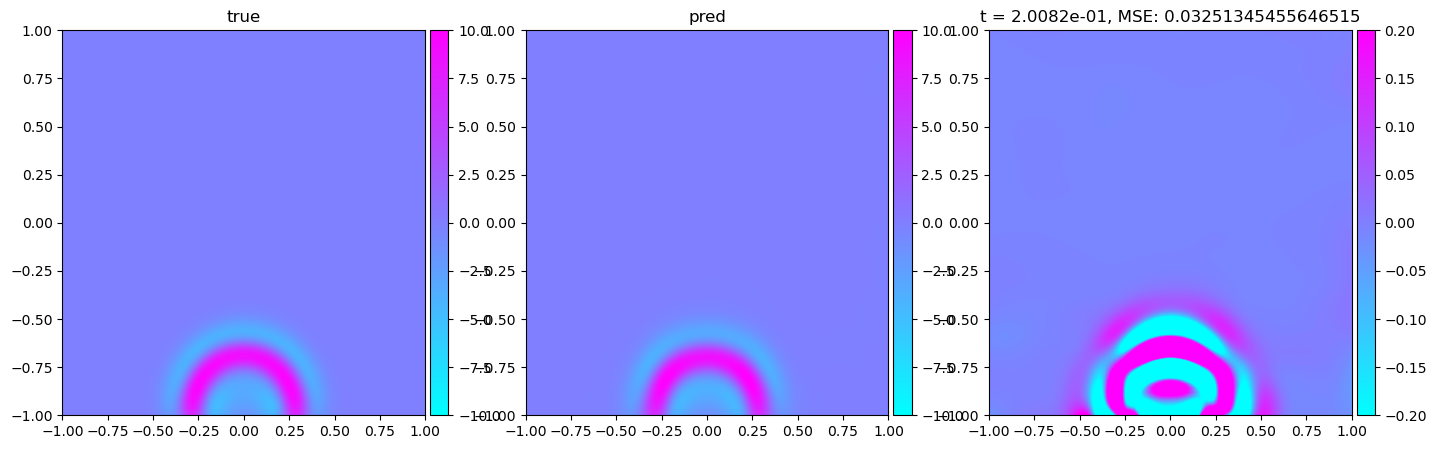

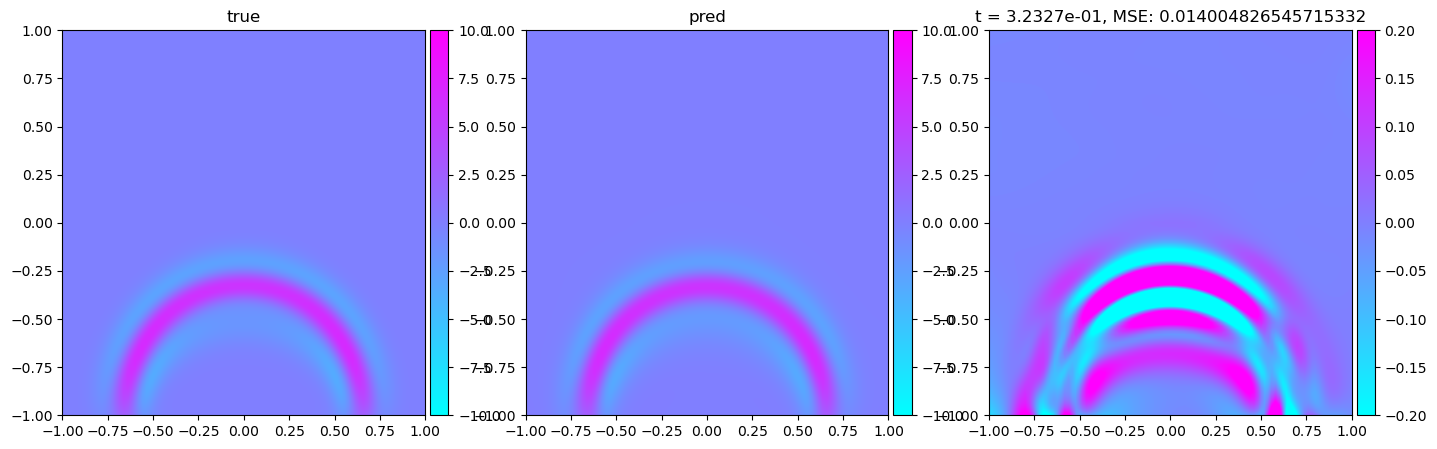

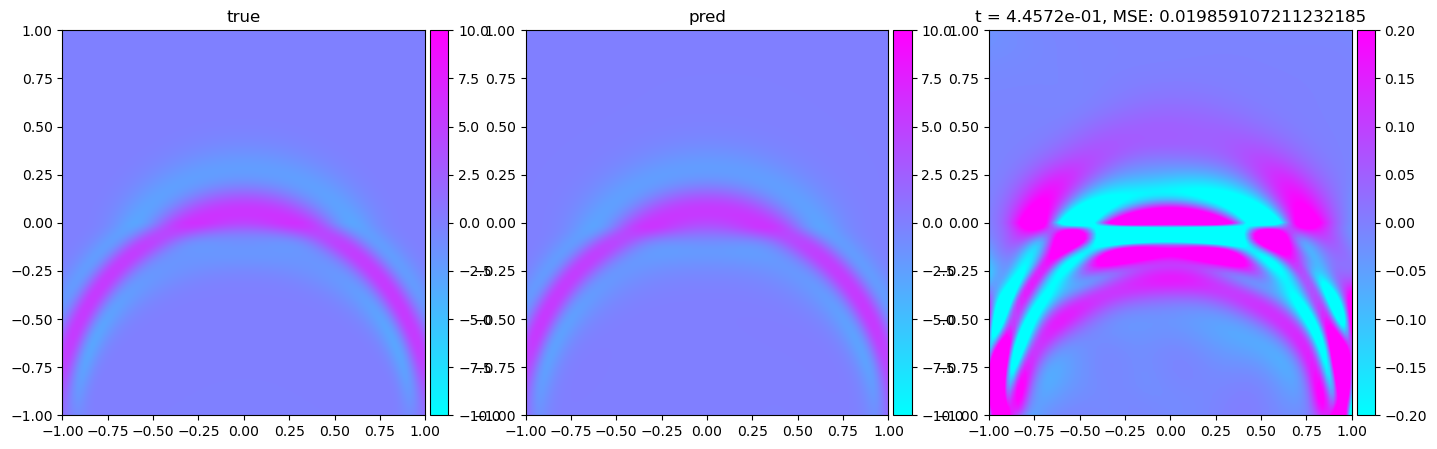

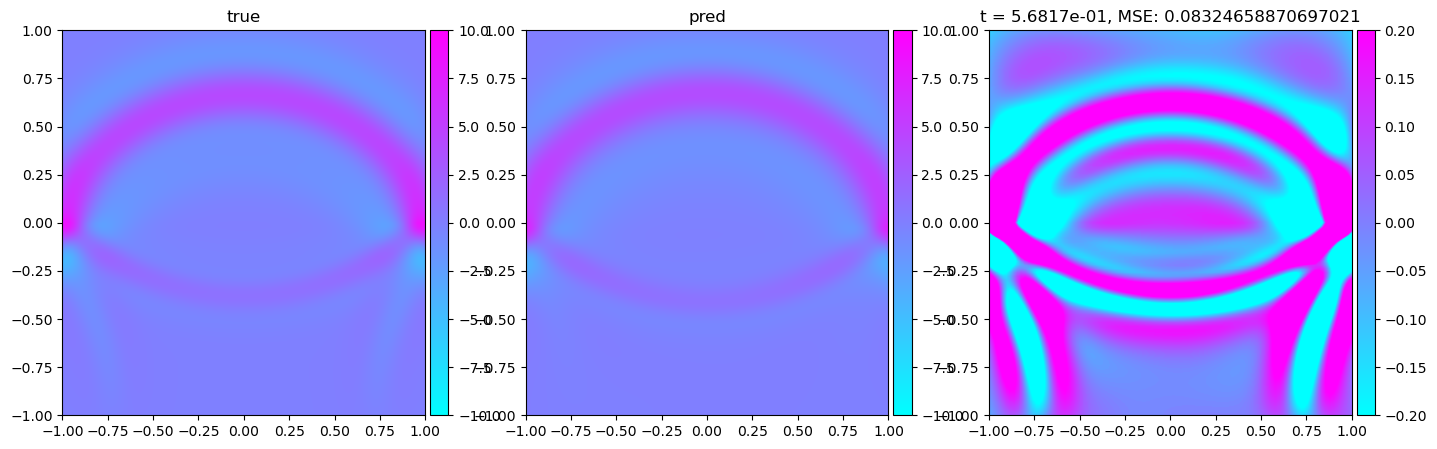

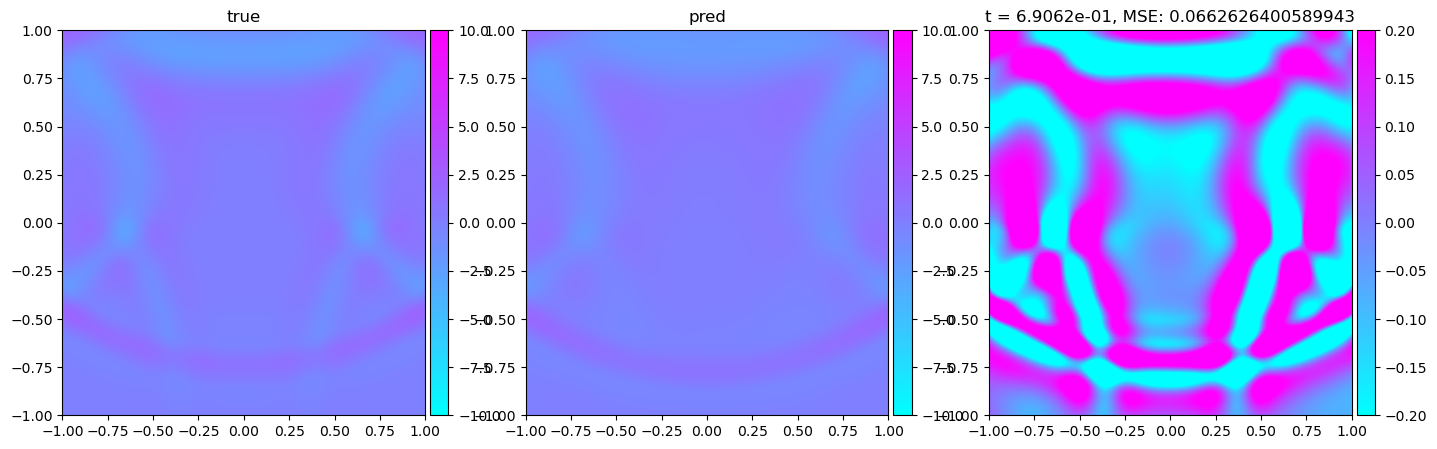

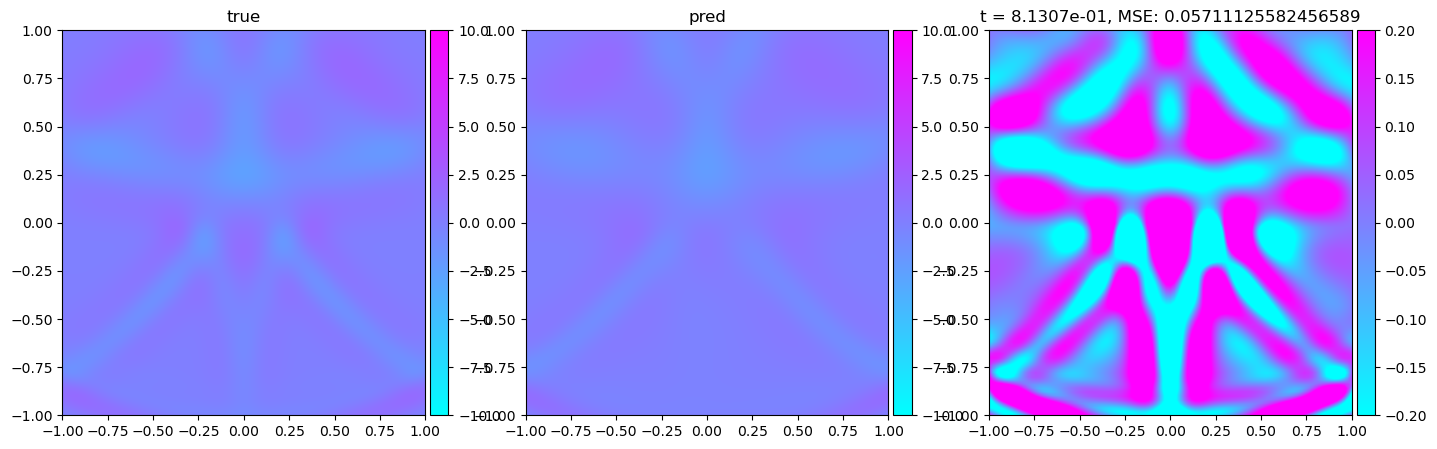

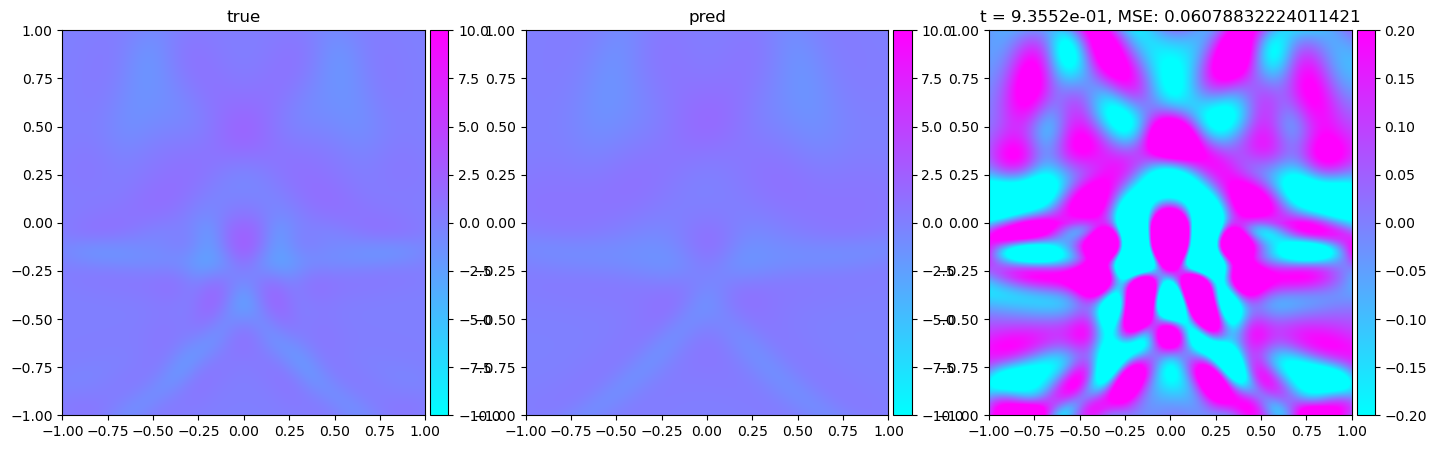

In [16]:
for i in range(0, len(t), 50):
	plot_(i)